# Data Mining Project on Human Activity Recognition

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from utils import timeseries_visualization, load_data, visualize_hist_and_boxplot, visualize_pca
np.random.seed(1)
random.seed(1)


## Exploratory Data Analysis


The first step is loading the data. The dataset consists of sensor data measured on 18 separate subjects, which is stored in 18 separate csv file. 
As such, we will combine all the files in a single dataframe, adding a feature 'subject' which contains the subject id, because it might be helpful for classification purposes

In [2]:
df = load_data()
df

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,subject_id
0,2021-03-24 14:42:03.839,-0.999023,-0.063477,0.140625,-0.980469,-0.112061,-0.048096,6,501
1,2021-03-24 14:42:03.859,-0.980225,-0.079346,0.140625,-0.961182,-0.121582,-0.051758,6,501
2,2021-03-24 14:42:03.880,-0.950195,-0.076416,0.140625,-0.949463,-0.080566,-0.067139,6,501
3,2021-03-24 14:42:03.900,-0.954834,-0.059082,0.140381,-0.957520,-0.046143,-0.050781,6,501
4,2021-03-24 14:42:03.920,-0.972412,-0.042969,0.142822,-0.977051,-0.023682,-0.026611,6,501
...,...,...,...,...,...,...,...,...,...
2259592,2021-06-11 11:13:14.098,-0.960693,-0.199951,-0.330566,-0.977051,0.006104,-0.246826,1,518
2259593,2021-06-11 11:13:14.118,-0.942627,-0.210205,-0.331543,-0.969482,0.004883,-0.231445,1,518
2259594,2021-06-11 11:13:14.138,-0.907227,-0.190918,-0.320312,-1.048096,0.067627,-0.234375,1,518
2259595,2021-06-11 11:13:14.159,-0.883057,-0.156982,-0.311279,-1.007080,0.063965,-0.248047,1,518


Let's visualize the data of one subject from the back and thigh sensors. The data is a timeseries, so we will plot the activity recorded by the sensors as a function of the timesteps, so we can see the evolution over time

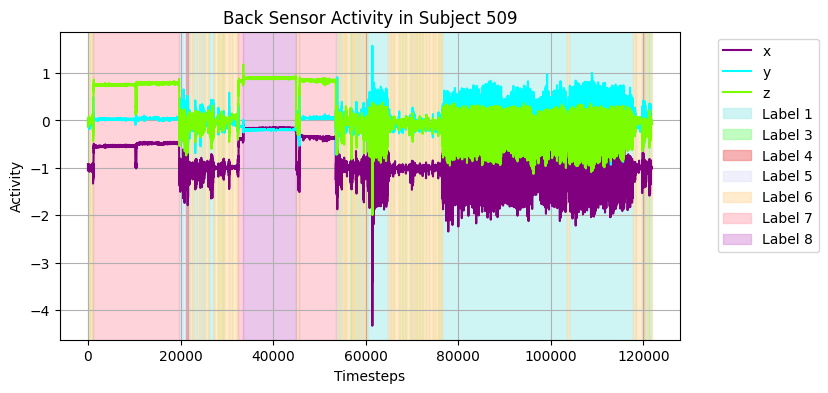

In [3]:
timeseries_visualization(df, 509, 'Back Sensor Activity in Subject 509', 'back')

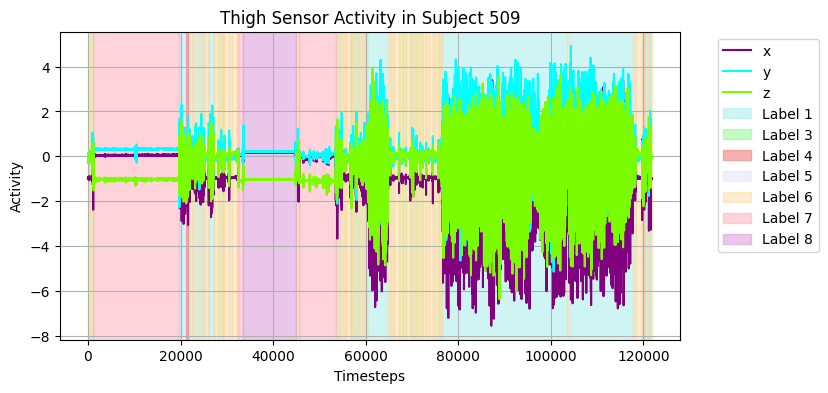

In [4]:
timeseries_visualization(df, 509, 'Thigh Sensor Activity in Subject 509', 'thigh')

From the accelerometor plot, we notice some important characteristics of the dataset.
    
1) The data seem to vary considerably between the classes. More specifically, for label 1 it is much more fluctuating while it tends to stay between a smaller range for labels 4, 8 and 6.

2) There are clearly some patterns that can help us identify the classes.

3) There are not many records for labels 3, 4, and 5 compared to the rest of the data. This might make it challenging  for a classifier to distinguish samples belonging to this class. As such, for this study, we decide to remove these samples from the dataset and only work on recognizing other activities

4) Since the data is very fluctuating for label 1, it might be useful to introduce lagged features for classification purposes, because the differences between the activity for label 1 at one timesteps and the previous can be substantially large compared to the rest of the labels

The data is multidimensional, as such it poses challenges for visualization purposes. It can be useful to do PCA and plot the first two principal components 

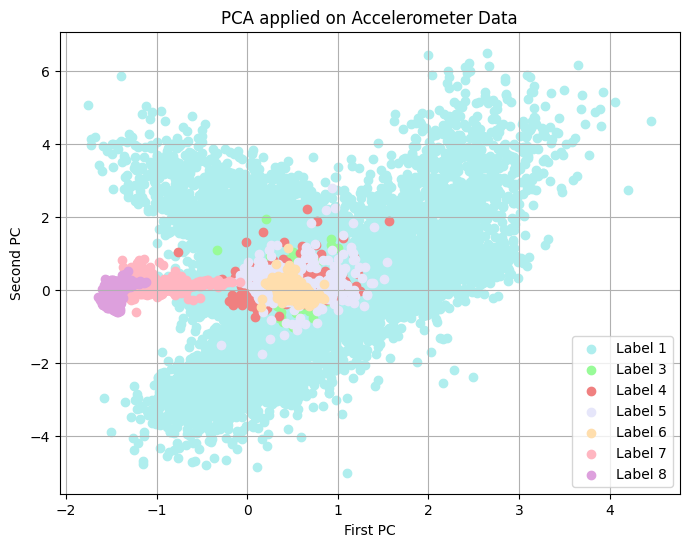

In [5]:
visualize_pca(df, 509)

Looking at the PCA, we notice 2 things:
1)  The points in class 7, 8 seem to form distinct clusters. We expect the classifier to find it somewhat easy to not misclassify one class for another 

2)  The points in class 5, 6, 3 and 4 seem to overlap with each other. It might be complex to distinguish them, so that's another reason why we will discard for this project the labels 3,4 and 5

3) The majority class (1) seems to overlap between every class. It may not be particularly suited to the dataset to apply kMeans clustering since the clusters are not linearly separated. The dataset is also clearly unbalanced, and we need to take care of this. 


## Data preprocessing

### Outlier detection

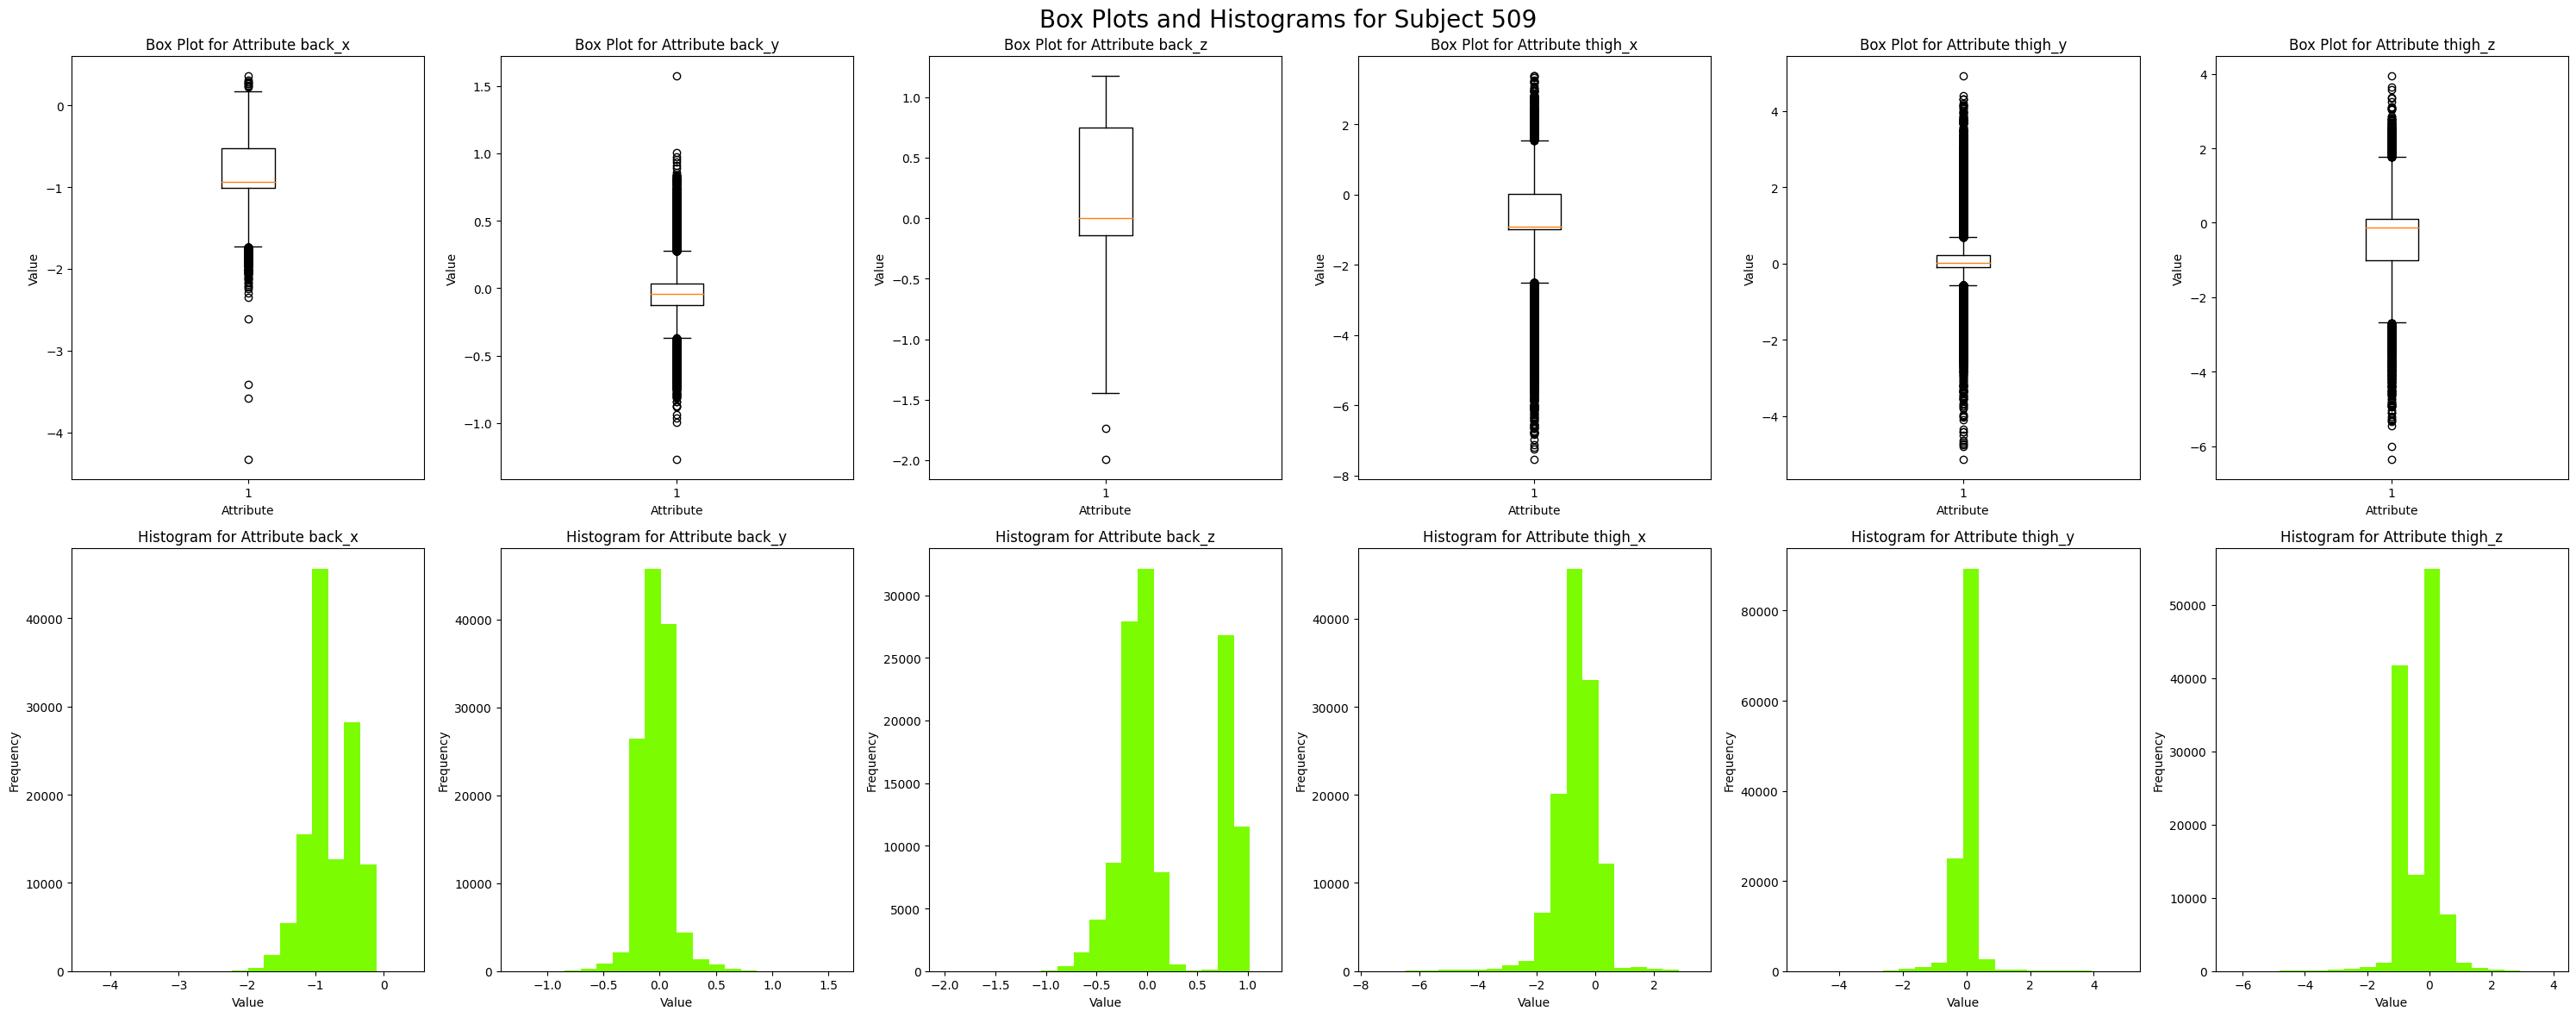

In [3]:
visualize_hist_and_boxplot(df, 509) 

The dataset presents a lot of outliers, discarding them might be helpful for the classifier.